## Problem Statement

### Business Context

Out of all renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.


## Objective

“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.


## Data Description

* Data provided is a transformed version of original data which was collected using sensors
* Train.csv - To be used for training and tuning of models
* Test.csv - To be used only for testing the performance of the final best model
* Both datasets consist of 40 predictor variables and 1 target variable


## Importing necessary libraries

In [1]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score,
    #plot_confusion_matrix,
)

#pip install imbalanced-learn --user

from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)

from xgboost import XGBClassifier

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

# To auto structure Python code
#%load_ext nb_black

## Loading dataset

In [2]:
df = pd.read_csv("Train.csv") ##  code to read train dataset
df_test = pd.read_csv("Test.csv") ## code to read test data

## Data Overview

### Checking shape of dataset

In [3]:
# Checking number of rows and columns in training data
df.shape

(20000, 41)

#### There are 41 columns and 20000 rows in train data set

In [4]:
# Checking number of rows and columns in test data
df_test.shape

(5000, 41)

#### There are 41 columns and 5000 rows in test data set

In [5]:
# copy of training data for further analysis
data = df.copy()

In [6]:
# copy of testing data for further use
data_test = df_test.copy()

### Displaying first few rows of dataset

In [7]:
# code to view first few rows of train data
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [8]:
# code to view last 5 rows of test data
data_test.tail(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
4995,-5.120,1.635,1.251,4.036,3.291,-2.932,-1.329,1.754,-2.985,1.249,-6.878,3.715,-2.512,-1.395,-2.554,-2.197,4.772,2.403,3.792,0.487,-2.028,1.778,3.668,11.375,-1.977,2.252,-7.319,1.907,-3.734,-0.012,2.120,9.979,0.063,0.217,3.036,2.109,-0.557,1.939,0.513,-2.694,0
4996,-5.172,1.172,1.579,1.220,2.530,-0.669,-2.618,-2.001,0.634,-0.579,-3.671,0.460,3.321,-1.075,-7.113,-4.356,-0.001,3.698,-0.846,-0.222,-3.645,0.736,0.926,3.278,-2.277,4.458,-4.543,-1.348,-1.779,0.352,-0.214,4.424,2.604,-2.152,0.917,2.157,0.467,0.470,2.197,-2.377,0
4997,-1.114,-0.404,-1.765,-5.879,3.572,3.711,-2.483,-0.308,-0.922,-2.999,-0.112,-1.977,-1.623,-0.945,-2.735,-0.813,0.610,8.149,-9.199,-3.872,-0.296,1.468,2.884,2.792,-1.136,1.198,-4.342,-2.869,4.124,4.197,3.471,3.792,7.482,-10.061,-0.387,1.849,1.818,-1.246,-1.261,7.475,0
4998,-1.703,0.615,6.221,-0.104,0.956,-3.279,-1.634,-0.104,1.388,-1.066,-7.970,2.262,3.134,-0.486,-3.498,-4.562,3.136,2.536,-0.792,4.398,-4.073,-0.038,-2.371,-1.542,2.908,3.215,-0.169,-1.541,-4.724,-5.525,1.668,-4.100,-5.949,0.550,-1.574,6.824,2.139,-4.036,3.436,0.579,0
4999,-0.604,0.960,-0.721,8.230,-1.816,-2.276,-2.575,-1.041,4.130,-2.731,-3.292,-1.674,0.465,-1.646,-5.263,-7.988,6.480,0.226,4.963,6.752,-6.306,3.271,1.897,3.271,-0.637,-0.925,-6.759,2.990,-0.814,3.499,-8.435,2.370,-1.062,0.791,4.952,-7.441,-0.070,-0.918,-2.291,-5.363,0


### Checking data types of columns for training dataset

In [9]:
## check data types of columns for train data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

#### Observations:

* All columns are numeric
* All column values are obtained from sensors placed on generators and are not anomalous data. So, they need not be treated (imputed/dropped) and can be used as is (per project description)
* Predictors V1 and V2 have 18 missing values each, needs missing value treatment
* All feature columns are float data type
* Target column is integer data type


### Checking for duplicate values

In [10]:
# check for duplicate values

data.duplicated().sum()

0

### Checking for missing values

In [11]:
# check for missing values in train data

data.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

#### Observations in train data:

* Predictors V1 and V2 are missing 18 values each
* There are no duplicate values

In [12]:
# check for missing values in test data

data_test.isnull().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

#### Observations in test data:

* V1 is missing 5 values
* V2 is missing 6 values

### Statistical summary of dataset

In [13]:
# statistical summary of the numerical columns in train data

data.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,19982.000,-0.272,3.442,-11.876,-2.737,-0.748,1.840,15.493
V2,19982.000,0.440,3.151,-12.320,-1.641,0.472,2.544,13.089
V3,20000.000,2.485,3.389,-10.708,0.207,2.256,4.566,17.091
V4,20000.000,-0.083,3.432,-15.082,-2.348,-0.135,2.131,13.236
V5,20000.000,-0.054,2.105,-8.603,-1.536,-0.102,1.340,8.134
V6,20000.000,-0.995,2.041,-10.227,-2.347,-1.001,0.380,6.976
V7,20000.000,-0.879,1.762,-7.950,-2.031,-0.917,0.224,8.006
V8,20000.000,-0.548,3.296,-15.658,-2.643,-0.389,1.723,11.679
V9,20000.000,-0.017,2.161,-8.596,-1.495,-0.068,1.409,8.138
V10,20000.000,-0.013,2.193,-9.854,-1.411,0.101,1.477,8.108


#### Observations:

* The range of values for all predictors is -21 to 24
* Predictor V3 has the highest mean of all predictors with a value of 2.485
* Predictor V21 has the lowest mean of all predictors with a value of -3.611


## Exploratory Data Analysis

### Univariate analysis

In [14]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

#### Plotting histograms and boxplots for all the variables

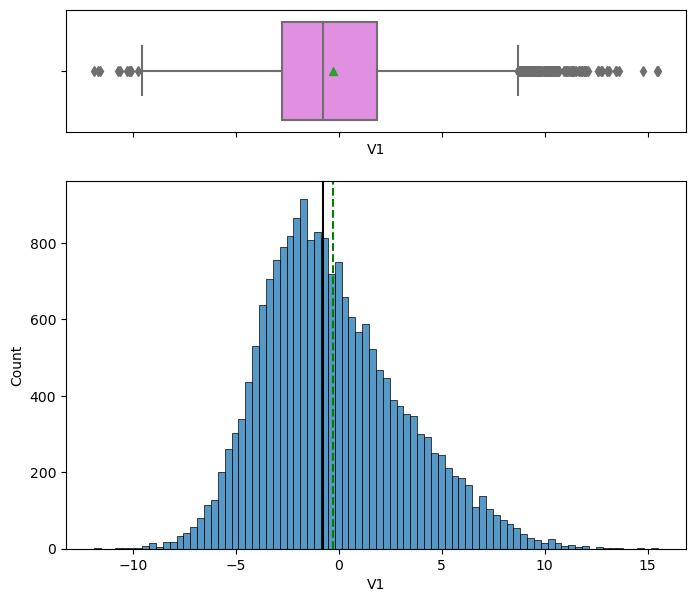

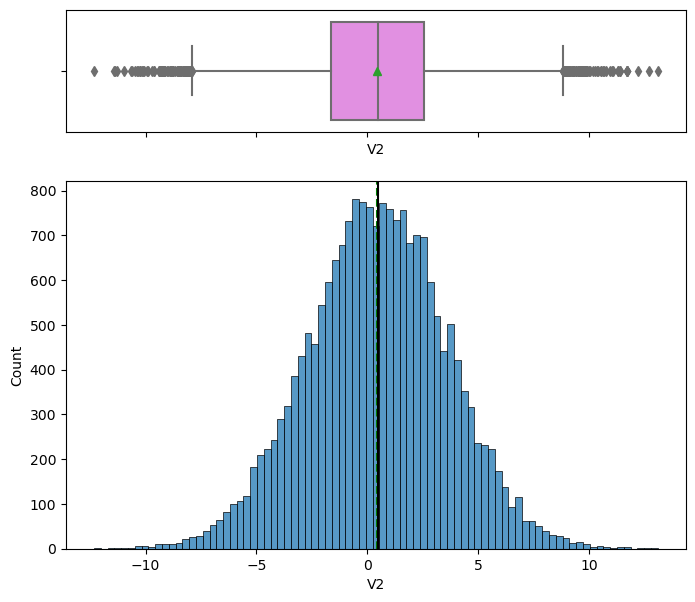

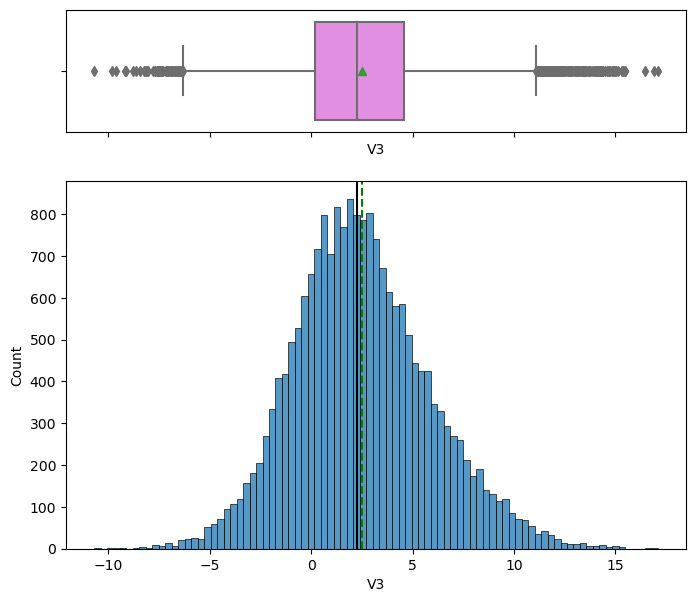

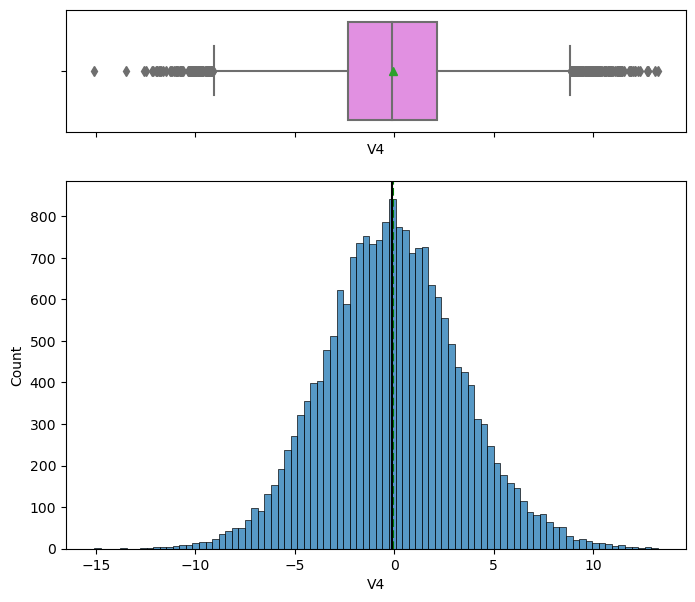

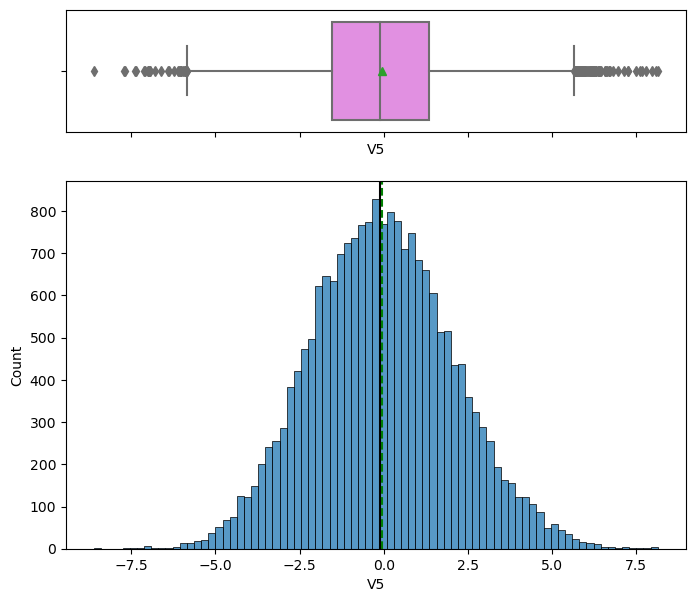

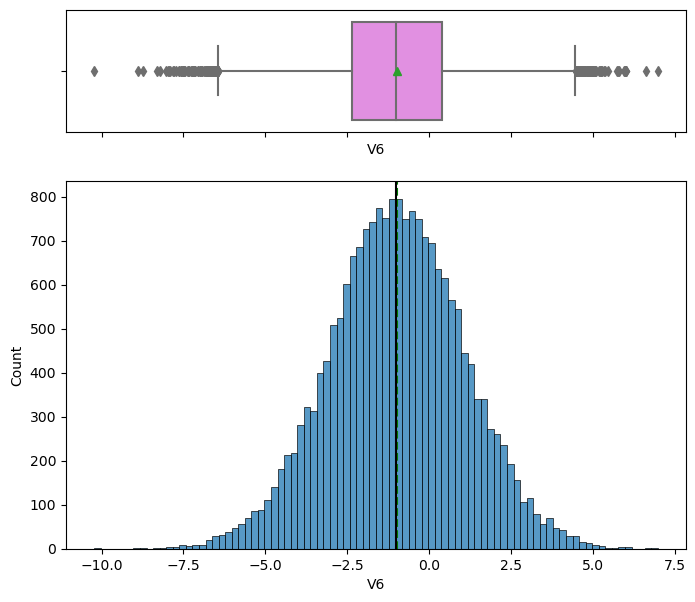

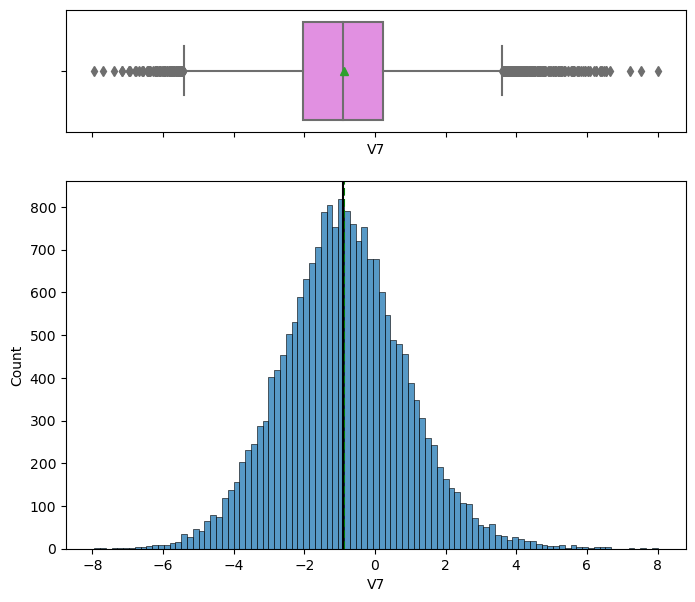

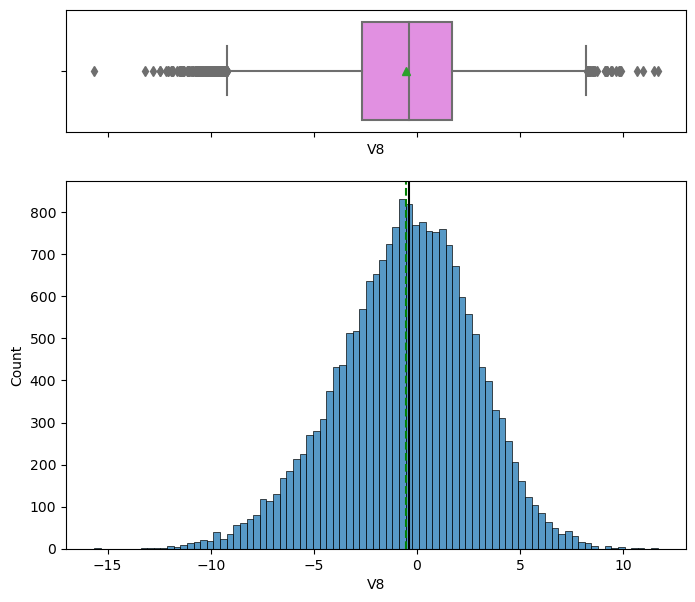

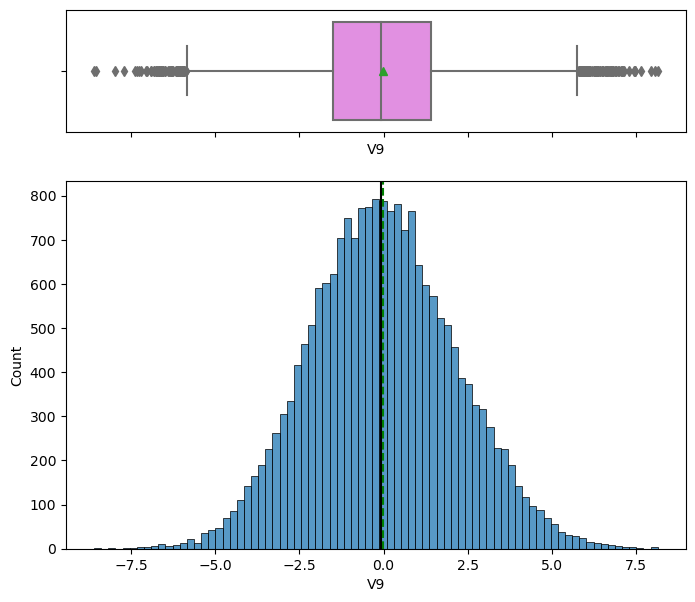

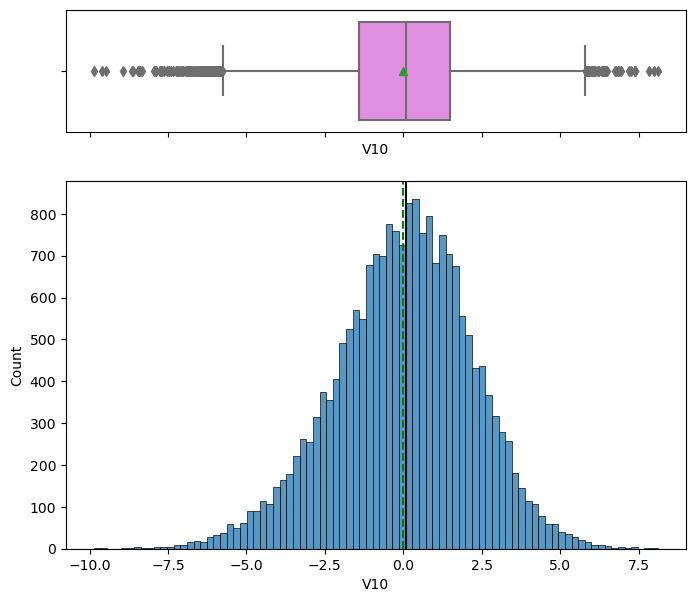

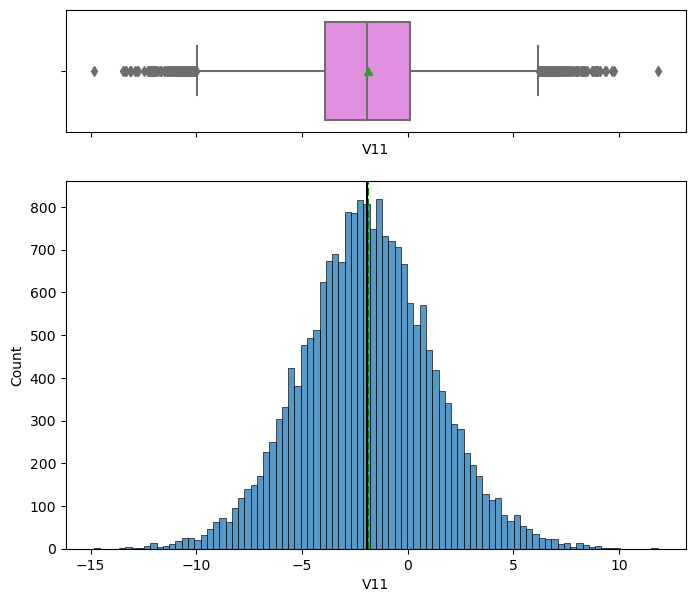

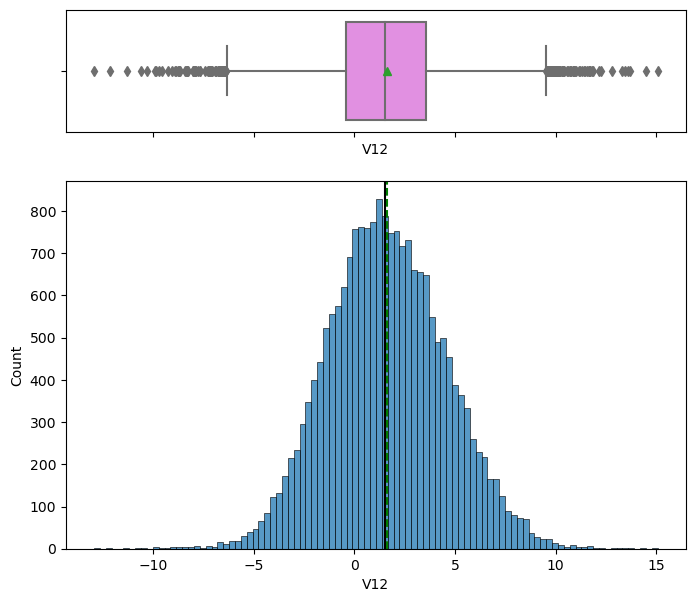

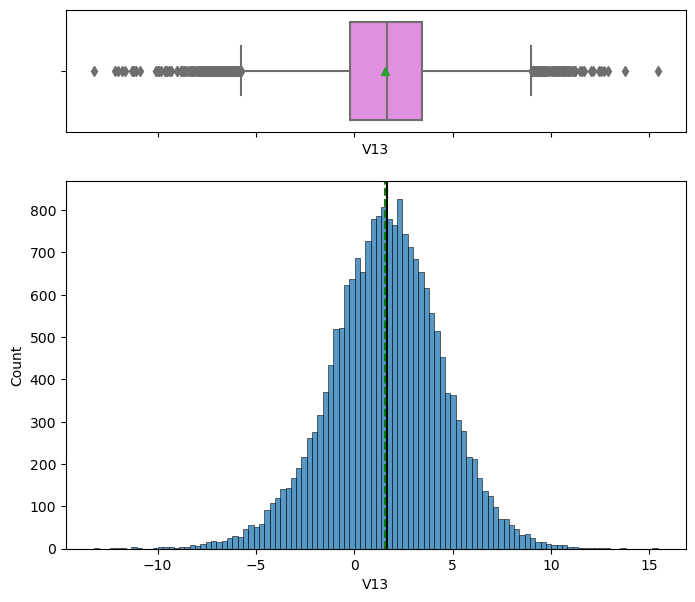

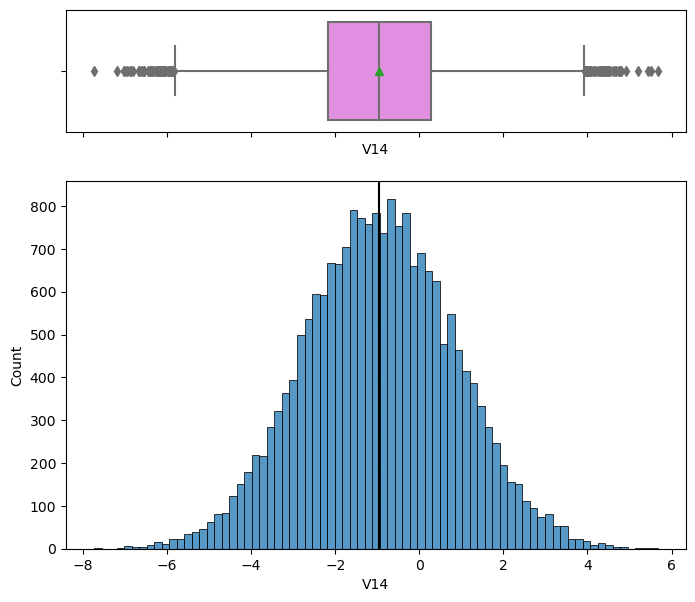

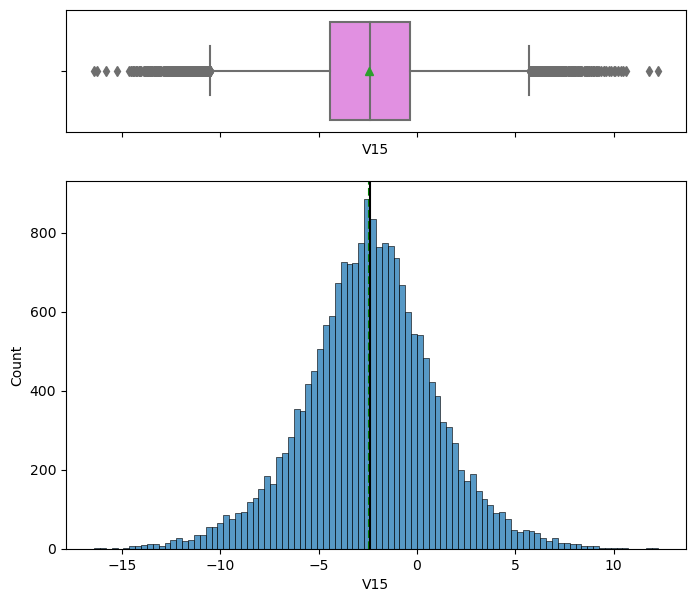

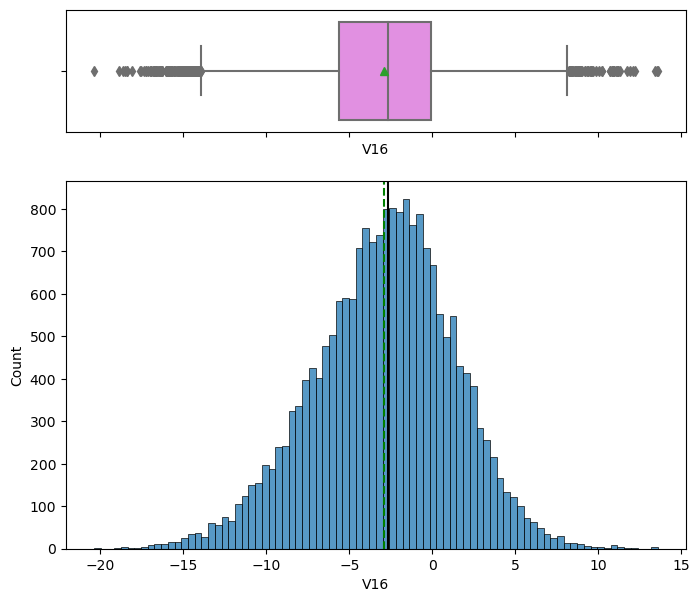

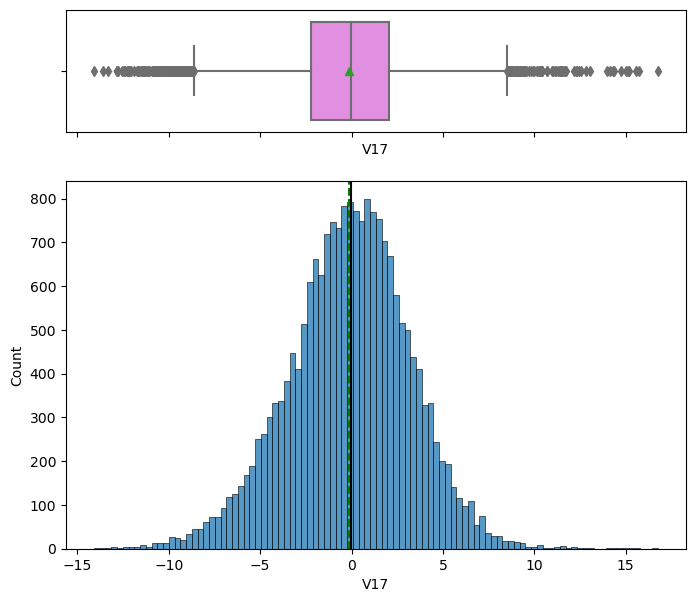

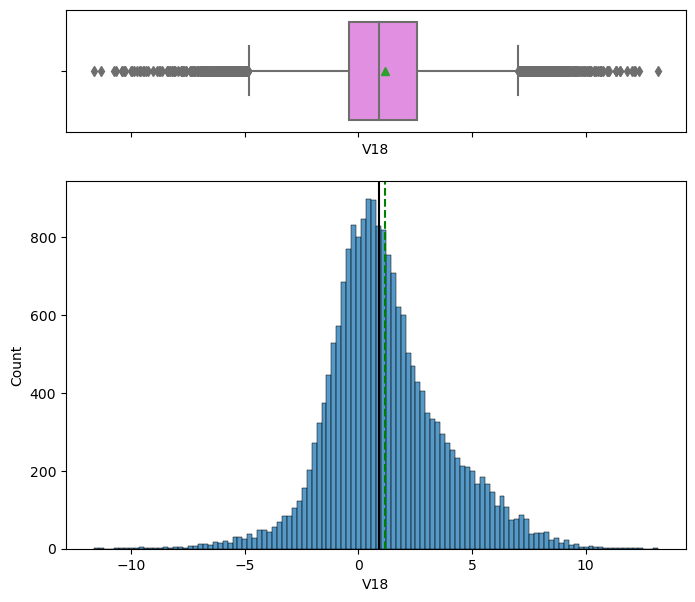

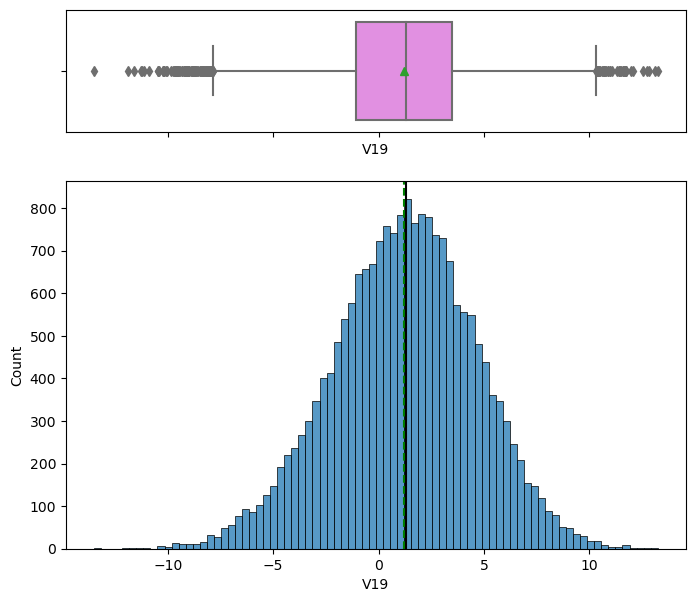

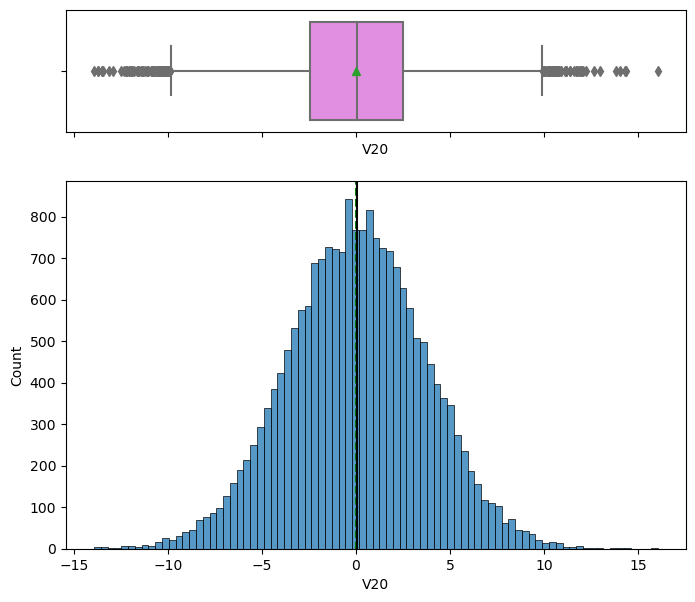

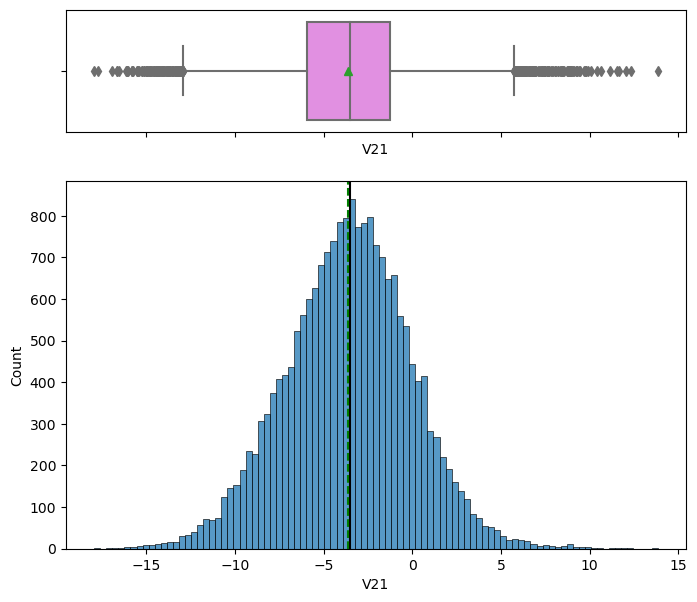

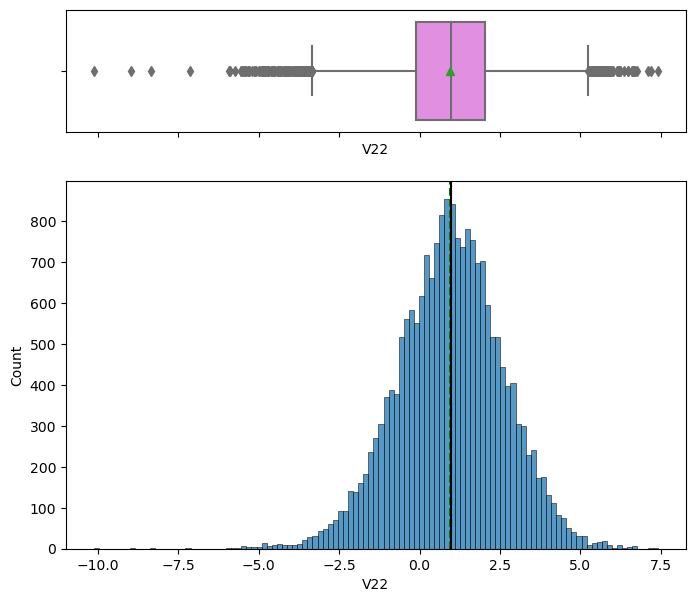

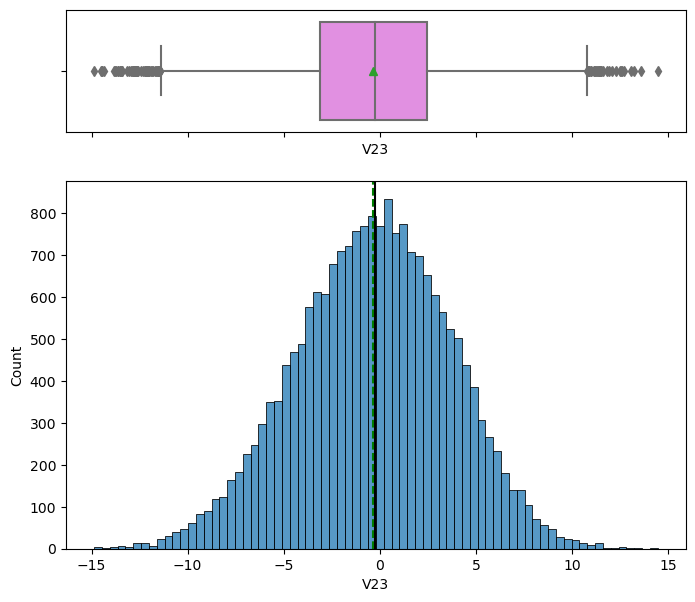

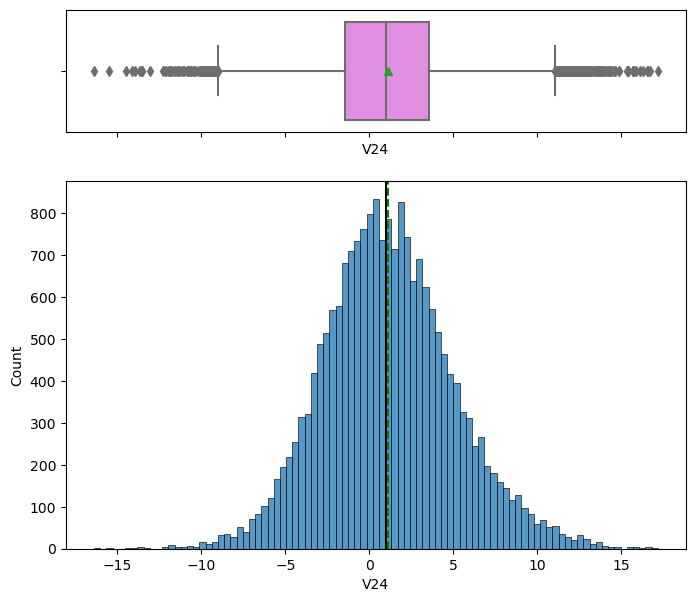

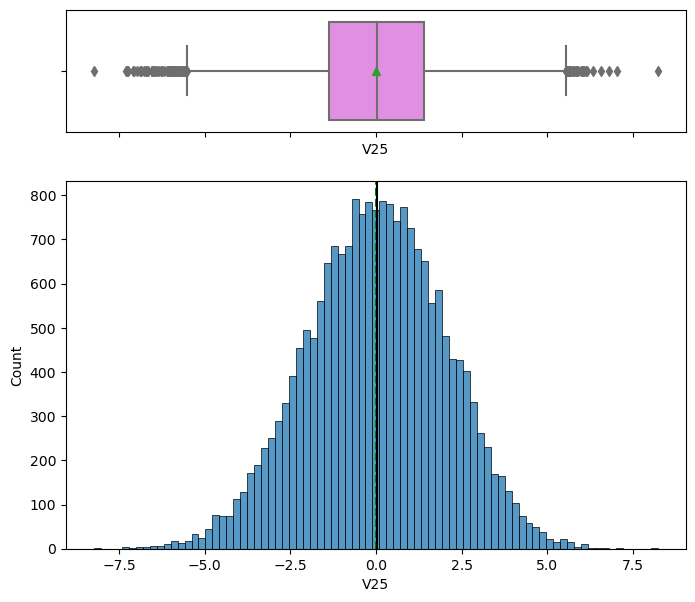

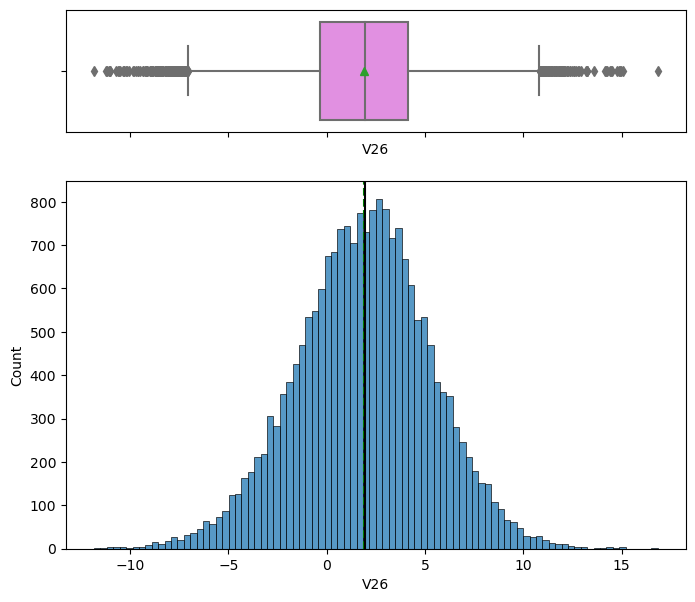

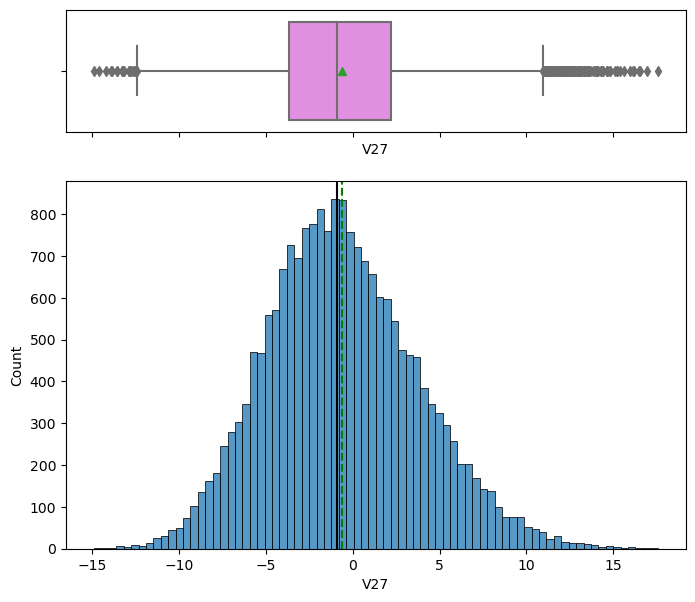

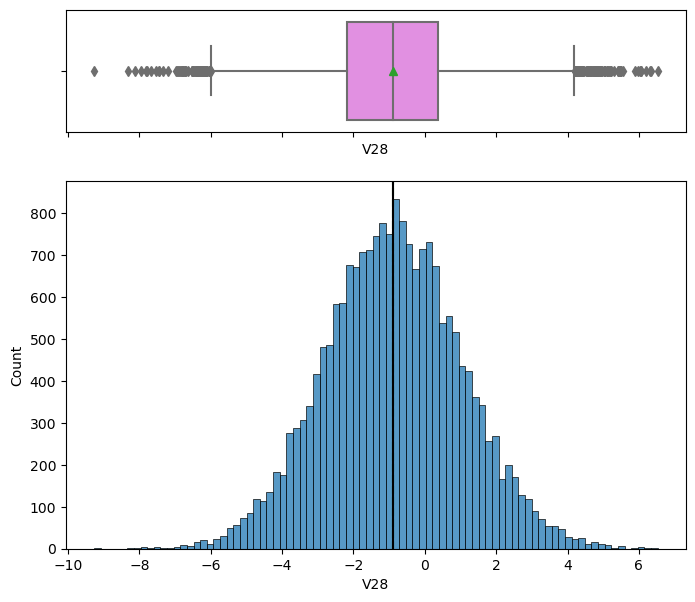

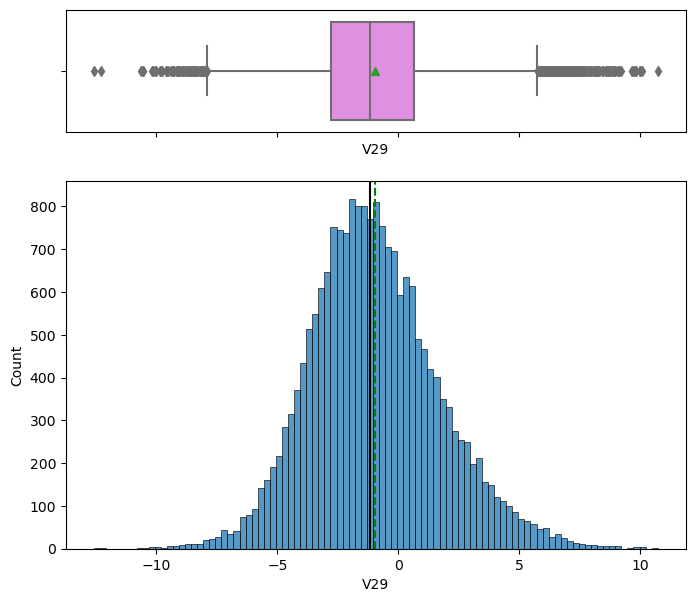

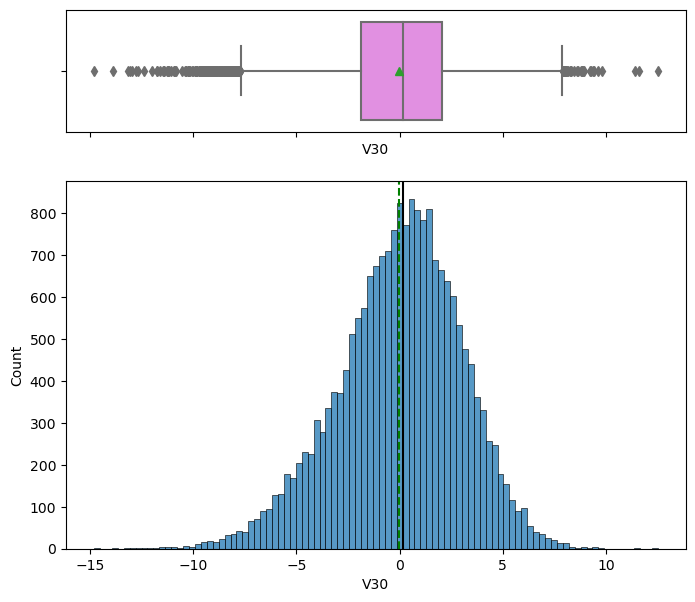

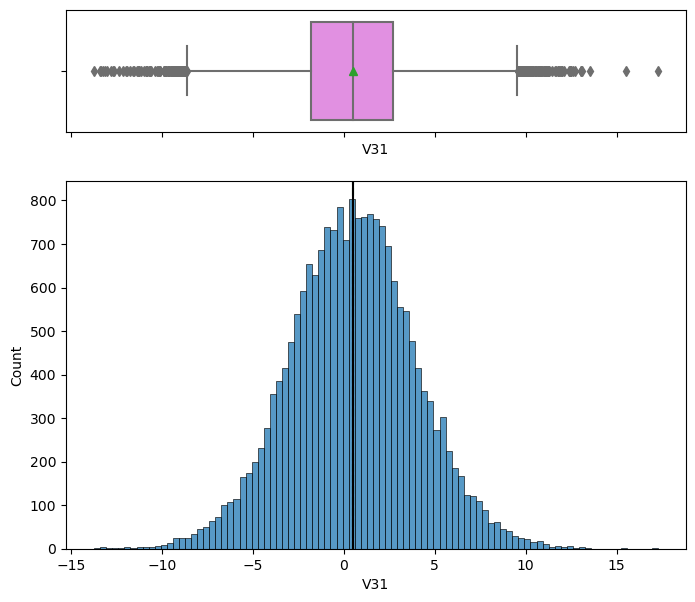

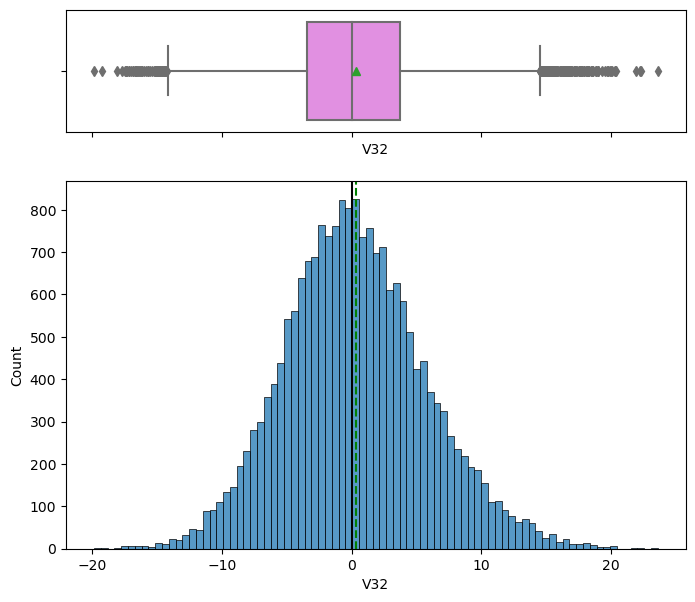

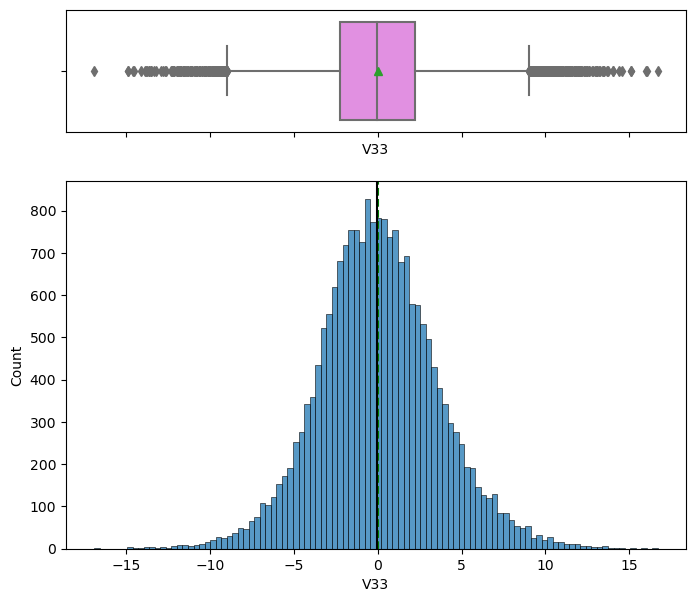

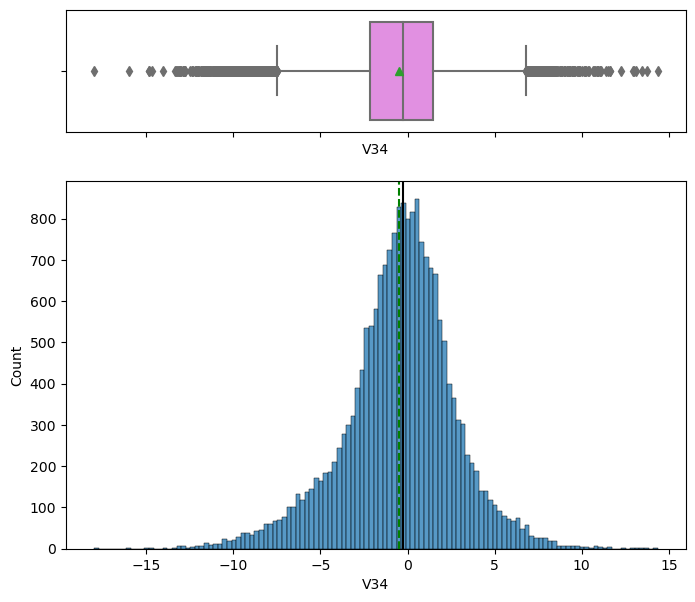

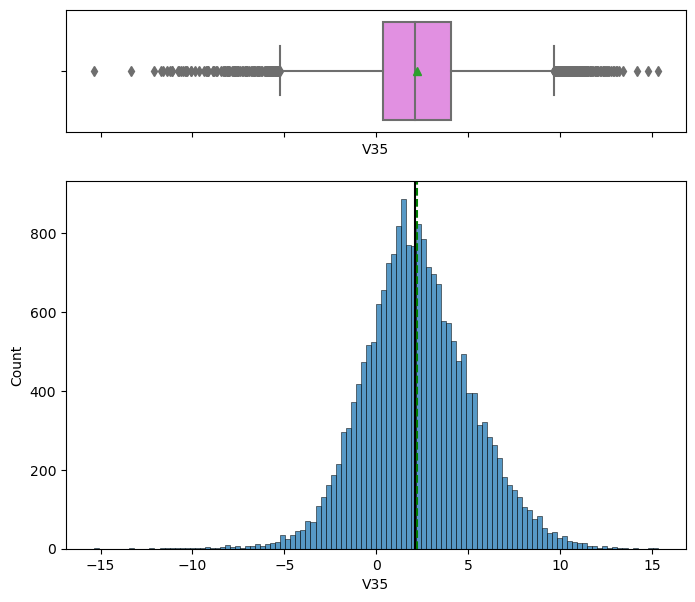

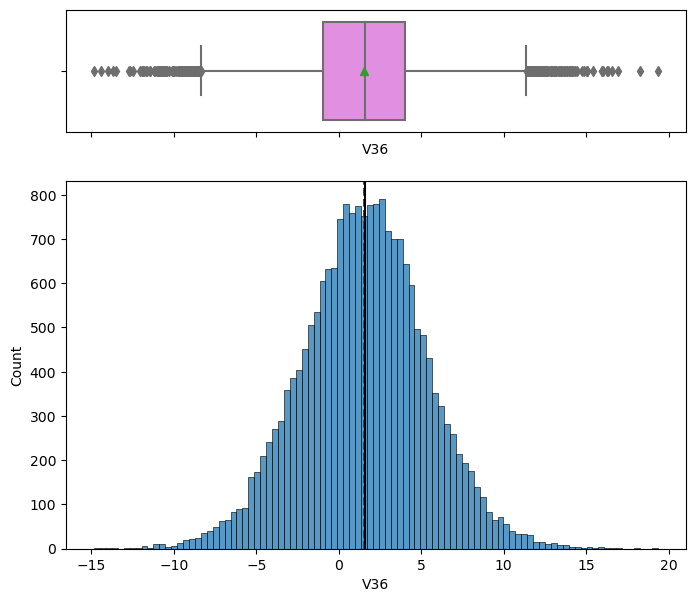

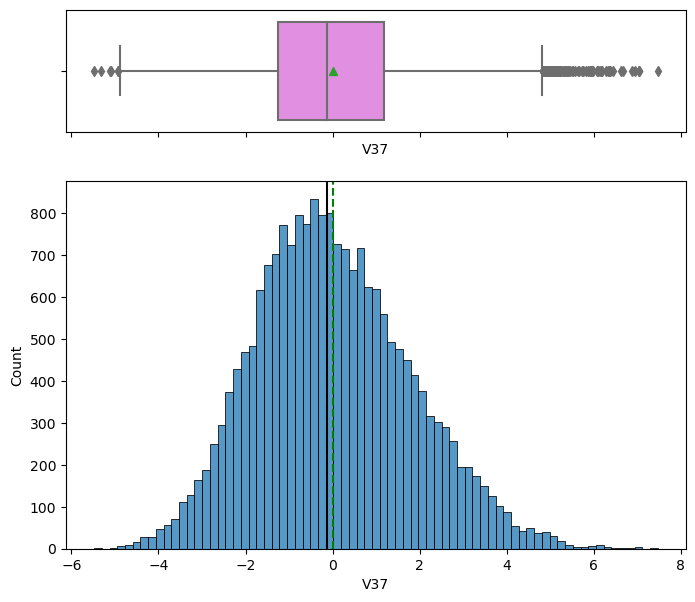

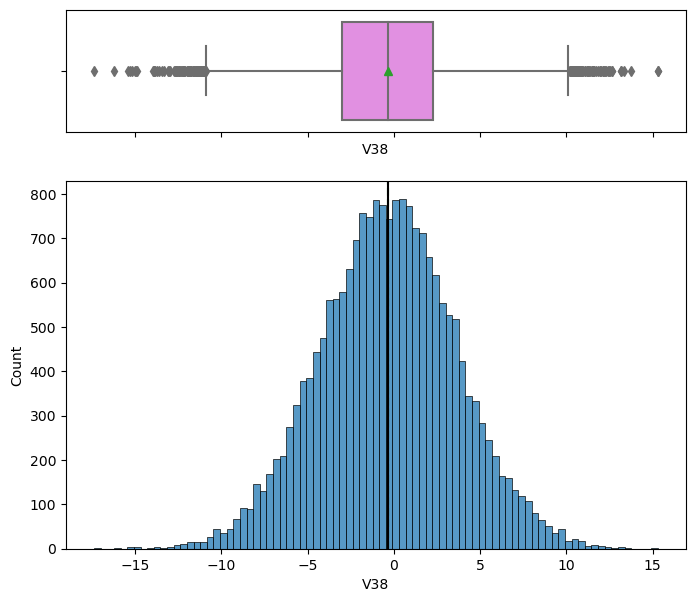

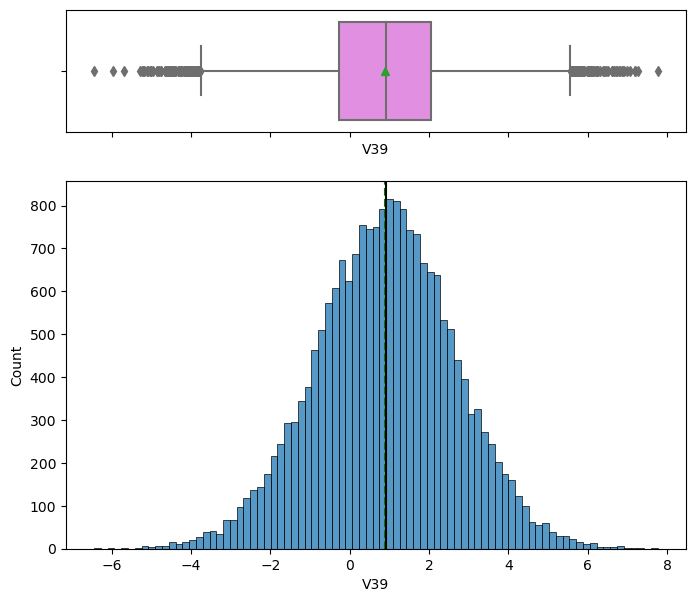

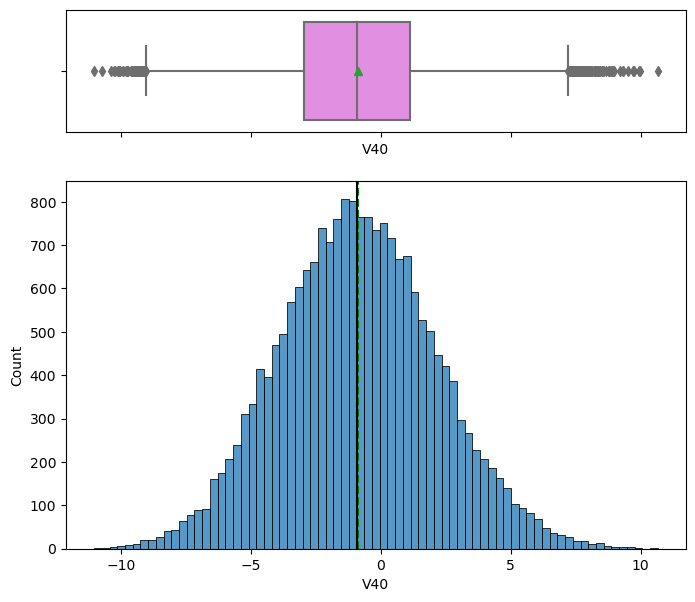

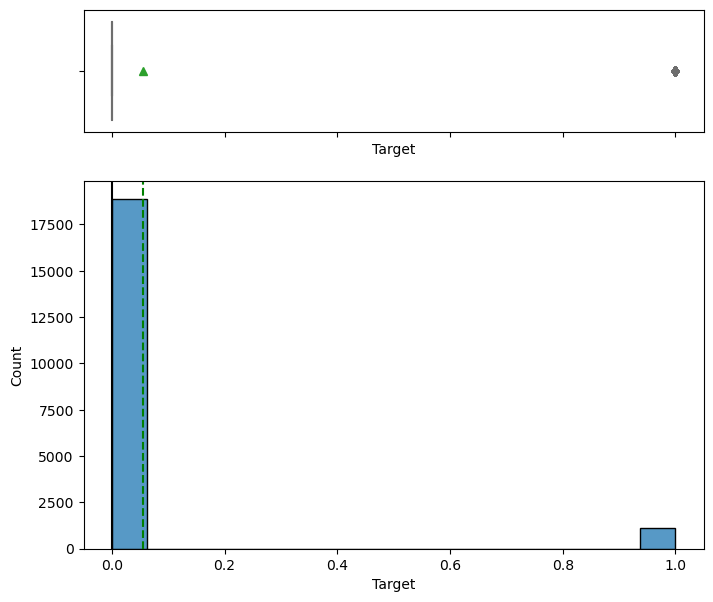

In [15]:
for feature in df.columns:
    histogram_boxplot(data, feature, figsize=(8, 7), kde=False, bins=None)

#### Observations:

* Majority of features are uniformally distributed in train data set
* Target values are between 0 or 1. "0" is the most common, which represents "no failure"
* There are extreme upper and lower values in almost all varaibles
* These are assumed to be legitimate and no outlier treatment to be performed


### Let's look at values in target variable

In [16]:
## class distribution in target variable for train data
data["Target"].value_counts()

0    18890
1     1110
Name: Target, dtype: int64

In [17]:
## class distribution in target variable for test data
data_test["Target"].value_counts()

0    4718
1     282
Name: Target, dtype: int64

#### Observations:

* Target class is imbalanced
* Target variables 0 and 1 are split in same ratio  between train and test data (95% of class 0, 5% of class 1)

## Data Pre-Processing

In [18]:
# Dividing train data into X and y 
X = data.drop(["Target"], axis=1)
y = data["Target"]

**Since we already have a separate test set, we don't need to divide data into train, valiation and test**


In [19]:
# Splitting train dataset into training and validation set in the ratio 75:25
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
    )


In [20]:
# Checking number of rows and columns in  X_train data
print(X_train.shape)

# Checking number of rows and columns in X_val data
print(X_val.shape)

(15000, 40)
(5000, 40)


#### Observations:

* There is 75:25 split between train and validation data


In [21]:
# Dividing test data into X_test and y_test

X_test = data_test.drop(["Target"],axis = 1)  ##  drop target variable from test data
y_test = data_test["Target"]  ## store target variable in y_test


In [22]:
# Checking number of rows and columns in X_test data
X_test.shape

(5000, 40)

#### Observations:

* Test data and validation data have same number of rows (5000)


## Missing value imputation




#### We will use median to impute missing values in "V1" and "V2" columns (as observed in Data Overview)

In [23]:
# creating an instace of the imputer to be used
imputer = SimpleImputer(strategy="median")

In [24]:
# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
## impute missing values in X_val without data leakage
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)

# Transform the test data
## impute missing values in X_test without data leakage
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns) 

In [25]:
# Checking that no column has missing values in train or test sets

print(X_train.isna().sum())  ## check count of missing values in train set
print("-" * 50)

print(X_val.isna().sum())   ## check count of missing values in validation set
print("-"*50)

print(X_test.isna().sum()) ## check count of missing values in test set

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
--------------------------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
--------------------------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0

#### Observations:

* There is no missing data in train, validation or test data

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [26]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
        },
        index=[0],
    )

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [27]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

**We are now done with pre-processing and evaluation criterion, let's start building models.**

### Model Building on original data

#### Logistic Regression, Decision Tree, Bagging, Random Forest, Gradient Boost, AdaBoost, XGBoost models

In [28]:
%%time

## Build Logistic Regression, Decision Tree, Bagging, Random Forest, Gradient Boost, AdaBoost, XGBoost 
## using default parameters

models = []  # Empty list to store all models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("DecisionTree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))


results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of models


# loop through all models to get mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.4927566553639709
DecisionTree: 0.6982829521679532
Bagging: 0.7210807301060529
Random Forest: 0.7235192266070268
GBM: 0.7066661857008874
Adaboost: 0.6309140754635308
Xgboost: 0.7956208065796118

Validation Performance:

Logistic regression: 0.48201438848920863
DecisionTree: 0.7050359712230215
Bagging: 0.7302158273381295
Random Forest: 0.7266187050359713
GBM: 0.7230215827338129
Adaboost: 0.6762589928057554
Xgboost: 0.8201438848920863
Wall time: 3min 44s


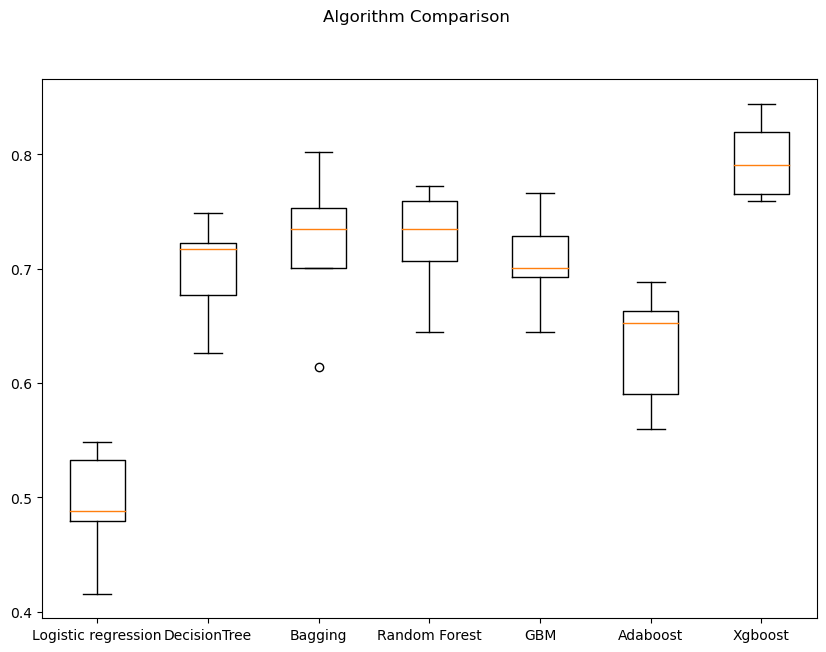

In [29]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

#### Observations on original models:

* 7 models with default parameters have been built
* CV scores for these models are similar across train and validation data
* This shows these models generalize well on original dataset
* Recall is metric of interest in this exercise, Recall score is to be maximised as it reduces false negatives
* Logistic Regression is not very efficient, recall score is about 0.49 in both train and validation data
* Decision Tree: train recall score (0.69) vs validation (0.70)
* Bagging: train recall (0.73) vs validation (0.73)
* Gradient Boost: train recall (0.70) vs validation (0.72)
* Random Forest: 0.72 on both train and validation
* AdaBoost: train recall score (0.63) vs validation (0.67)
* XGBoost: highest recall score(0.79) train vs (0.82) validation
* Most models seem reliable for optimization tuning


### Model Building with oversampled data

In [30]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 832
Before OverSampling, counts of label '0': 14168 

After OverSampling, counts of label '1': 14168
After OverSampling, counts of label '0': 14168 

After OverSampling, the shape of train_X: (28336, 40)
After OverSampling, the shape of train_y: (28336,) 



#### Observations:

* There are two ways to handle class imbalance in "Target" attribute - Oversampling and Undersampling
* Synthetic Minority Oversampling Technique or SMOTE method generates synthetic data points for minority class of importance (class "1" or No failures)
* Using SMOTE, class "1" and class "0" target outcomes are now equal
* lets build models using oversampled dataset


In [31]:
%%time
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("DecisionTree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_over = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    ) 
    results_over.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over,y_train_over)  ## code to build models on oversampled data 
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.883963699328486
DecisionTree: 0.9720494245534969
Bagging: 0.9762141471581656
Random Forest: 0.9839075260047615
GBM: 0.9256068151319724
Adaboost: 0.8978689011775473
Xgboost: 0.989554053559209

Validation Performance:

Logistic regression: 0.8489208633093526
DecisionTree: 0.7769784172661871
Bagging: 0.8345323741007195
Random Forest: 0.8489208633093526
GBM: 0.8776978417266187
Adaboost: 0.8561151079136691
Xgboost: 0.8669064748201439
Wall time: 8min 58s


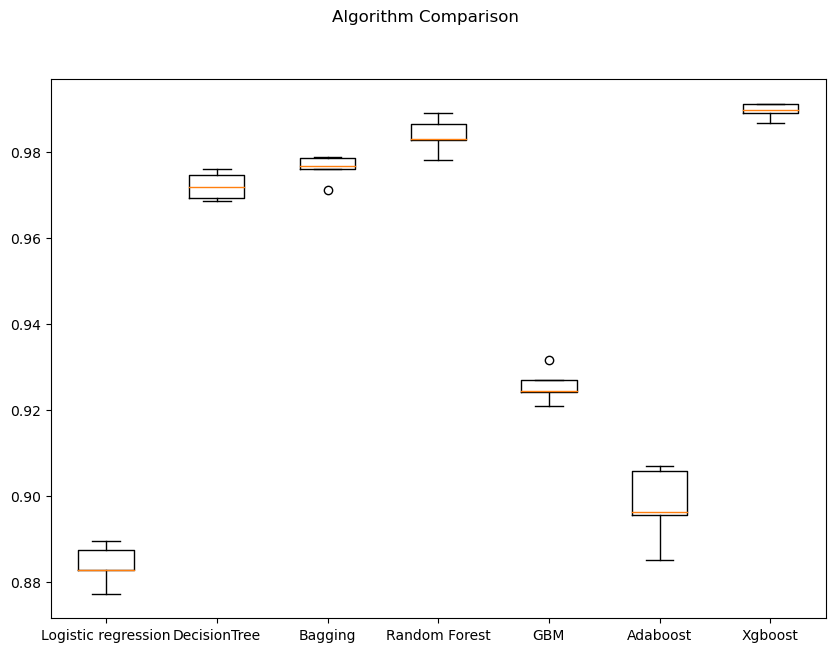

In [32]:
# Plotting boxplots for CV scores of all models on oversampled data defined above 

fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_over)
ax.set_xticklabels(names)

plt.show()


#### Observations on models with oversampled data

* CV scores on training and validation datasets have improved overall, compared to original models
* Crossvalidation score on training data is much higher compared to validation data score on oversampled data

* Logistic Regression: recall score train(0.88) vs validation (0.84) --> generalizes well
* Decision Tree: recall score train(0.97) vs validation (0.77) --> overfitting on training data
* Bagging: recall score train(0.97) vs validation (0.83) --> overfitting on training data
* Random Forest: recall score train(0.98) vs validation (0.83) --> overfitting on training data
* Gradient Boost: recall score train(0.92) vs validation (0.87) --> generalizes well
* Adaboost : recall score train(0.89) vs validation (0.85) --> generalizes well
* XGBoost: recall score train(0.98) vs validation (0.86) --> overfitting on training data


### Model Building with undersampled data

In [33]:
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 832
Before UnderSampling, counts of label '0': 14168 

After UnderSampling, counts of label '1': 832
After UnderSampling, counts of label '0': 832 

After UnderSampling, the shape of train_X: (1664, 40)
After UnderSampling, the shape of train_y: (1664,) 



#### Observations:

* There are two ways to handle class imbalance in "Target" attribute - Oversampling and Undersampling
* In Random undersampling, only random samples from majority class are chosen for model building
* This helps address overfitting, but characterized by loss of information from not considering all data points
* This could potentially produce poor performing models
* Using undersampling here, class "1" and class "0" target outcomes are equal
* Lets build models using undersampled dataset


In [34]:
%%time

models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("DecisionTree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("XGboost", XGBClassifier(random_state=1)))

results_under = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )  ## Code to build models on undersampled data
    results_under.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un,y_train_un)## code to build models on undersampled data 
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.8726138085275232
DecisionTree: 0.8617776495202367
Bagging: 0.8641945025611427
Random Forest: 0.9038669648654498
GBM: 0.8978572974532861
Adaboost: 0.8666113556020489
XGboost: 0.9074742082100858

Validation Performance:

Logistic regression: 0.8525179856115108
DecisionTree: 0.841726618705036
Bagging: 0.8705035971223022
Random Forest: 0.8920863309352518
GBM: 0.8884892086330936
Adaboost: 0.8489208633093526
XGboost: 0.9028776978417267
Wall time: 36.8 s


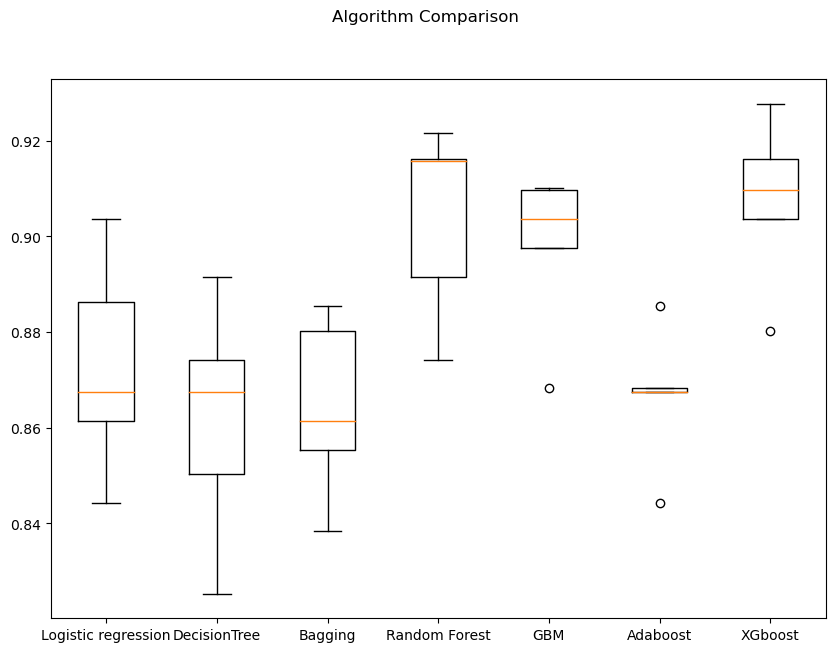

In [35]:
# Plotting boxplots for CV scores of all models on undersampled data defined above 

fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_under)
ax.set_xticklabels(names)

plt.show()


#### Observations on models after undersampling:

* CV Recall scores on training and validation undersampled datasets are comparable
* Recall scores on both training and validation datasets have improved compared to original dataset
* These models seem to be generalizing well overall

* Logistic Regression: recall score train(0.87) vs validation (0.85)
* Decision Tree: recall score train(0.86) vs validation (0.84)
* Bagging: recall score train(0.86) vs validation (0.87)
* Random Forest: recall score train(0.90) vs validation (0.89)
* Gradient Boost: recall score train(0.89) vs validation (0.88)
* Adaboost : recall score train(0.86) vs validation (0.84)
* XGBoost: recall score train(0.90) vs validation (0.90)
* These models generalize well and are reliable towards tuning optimization


#### Which models do we hypertune?

**After looking at performance of all models, let's decide which models can further improve with hyperparameter tuning.** 

* Logistic Regression: original model (least recall on train and validation), generalized ok on over/undersamped datasets
* Decision tree: original model generalized ok, oversampled data: overfitting tendency, undersampled data: generalizes ok
* Bagging: original model generalized ok, oversampled data: overfitting tendency, undersampled data: generalized ok
* Random Forest: original model generalized ok, oversampled data: overfitting tendency, undersampled data: generalized ok
* Gradient Boost: original model generalized ok, oversampled data: generalized ok, undersampled data: generalized ok
* Adaboost: original model lowest validation score, oversampled data: generalized ok, undersampled data: generalized ok
* XGBoost: original model generalized ok, oversampled data: overfitting tendency, undersampled data: generalized ok, has highest recall among all models

* Considering above matrix, Decision Tree (undersampled), Adaboost (oversampled), RandomForest(undersampled), GradientBoost (oversampled) and XGBoost(oversampled) are the 5 models chosen for hypertuning
* These models will be hypertuned using RandomSearchCV method due to its computational efficiency over Gridsearch technique


## Hyperparameter Tuning

### 1) Tuning Decision Tree using undersampled data

In [36]:
%%time 

# defining model
Model = DecisionTreeClassifier(random_state=1)

# parameter grid to pass in RandomSearchCV

param_grid = { 'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10, 15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   n_jobs = -1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': 5} with CV score=0.5684366207344347:
Wall time: 9.68 s


In [37]:
# Creating new pipeline with best parameters

tuned_dtree = DecisionTreeClassifier(
    min_samples_leaf=7,
    min_impurity_decrease=0.0001,
    max_leaf_nodes=15,
    max_depth=5
) 

tuned_dtree.fit(X_train_un, y_train_un) ## code to fit model on undersampled data

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=15,
                       min_impurity_decrease=0.0001, min_samples_leaf=7)

In [38]:
## code to check performance on undersampled train dataset
dtree_train_perf = model_performance_classification_sklearn(tuned_dtree, X_train_un, y_train_un)
dtree_train_perf

,Accuracy,Recall,Precision,F1
0,0.889,0.879,0.898,0.888


In [39]:
## code to check performance on validation dataset
dtree_val_perf = model_performance_classification_sklearn(tuned_dtree, X_val, y_val)
dtree_val_perf

,Accuracy,Recall,Precision,F1
0,0.874,0.878,0.290,0.436


#### Observations on tuned DecisionTree using undersampled data

* Best hyperparameters for Decision Tree: max_depth=5, max_leaf_nodes=15, min_impurity_decrease=0.0001, min_samples_leaf=7
* Recall on train data: 87.8% vs Recall on validation data: 86%
* Accuracy: 88.9% (train) vs  87.4% (validation)
* Precision: 89.8% (train) vs 29% (validation) --> low precision
* F1 score: 88.8% (train) vs 43.6% (validation) --> low F1


###  2) Tuning AdaBoost using oversampled data

In [40]:
%%time 

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), 
                       DecisionTreeClassifier(max_depth=2, random_state=1),
                       DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, 
                                   n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over) ## code to fit model on over sampled data

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9715559462639259:
Wall time: 32min 16s


In [41]:
# Creating new pipeline with best parameters

tuned_ada = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=.2,
    random_state=1,
    base_estimator=DecisionTreeClassifier(max_depth=3, random_state=1),
)

tuned_ada.fit(X_train_over, y_train_over) ## Complete the code to fit the model on oversampled data

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200, random_state=1)

In [42]:
## code to check performance on oversampled train dataset
ada_train_perf = model_performance_classification_sklearn(tuned_ada, X_train_over, y_train_over)
ada_train_perf

,Accuracy,Recall,Precision,F1
0,0.992,0.988,0.995,0.992


In [43]:
## code to check performance on validation dataset
ada_val_perf = model_performance_classification_sklearn(tuned_ada, X_val, y_val)
ada_val_perf

,Accuracy,Recall,Precision,F1
0,0.979,0.853,0.790,0.820


#### Observations on tuned AdaBoost Classifier using oversampled data

* Best parameters are shown below: 
* n_estimators: 200, learning_rate: 0.2, base_estimator: DecisionTreeClassifier(max_depth=3, random_state=1)
* Recall on train data: 98.8% vs Recall on validation data: 85.3%
* Accuracy: 99.2% (train) vs  97.9% (validation)
* Precision: 99.5% (train) vs 79% (validation) --> not great
* F1 score: 99.2% (train) vs 82% (validation)
* Model run time ~ 32min


### 3) Tuning Random forest using undersampled data

In [44]:
%%time 

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid,
                                   n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)   ## code to fit the model on under sampled data

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'sqrt'} with CV score=0.8990116153235697:
Wall time: 42.4 s


In [45]:
# Creating new pipeline with best parameters
tuned_rf2 = RandomForestClassifier(
    max_features='sqrt',
    random_state=1,
    max_samples=0.5,
    n_estimators=300,
    min_samples_leaf=2,
)

tuned_rf2.fit(X_train_un,y_train_un)  ## fit the model on under sampled data

RandomForestClassifier(max_features='sqrt', max_samples=0.5, min_samples_leaf=2,
                       n_estimators=300, random_state=1)

In [46]:
## check performance on undersampled train set
rf2_train_perf = model_performance_classification_sklearn(tuned_rf2,X_train_un,y_train_un)
rf2_train_perf

,Accuracy,Recall,Precision,F1
0,0.961,0.933,0.989,0.960


In [47]:
## check performance on validation set
rf2_val_perf = model_performance_classification_sklearn(tuned_rf2,X_val,y_val)
rf2_val_perf

,Accuracy,Recall,Precision,F1
0,0.938,0.885,0.468,0.612


#### Observations on tuned RandomForest model using undersampled data:

* Best parameters for RandomForest using RandomsearchCV are shown below
* n_estimators - 300, min_samples_leaf - 2, max_samples - 0.5, max_features - 'sqrt'
* Recall on train data: 93.3%  vs Recall on validation data: 88.5%
* Accuracy: 96.1% (train) vs  93.8% (validation)
* Precision: 98.9% (train) vs 46.8% (validation) --> low precision
* F1 score: 96% (train) vs 61.2% (validation) --> low F1


### 4) Tuning Gradient Boost using oversampled data

In [48]:
%%time 

# defining model
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid={"n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], 
            "subsample":[0.5,0.7], "max_features":[0.5,0.7]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, scoring=scorer, 
                                   n_iter=50, n_jobs = -1, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9724734023671514:
Wall time: 8min 19s


In [49]:
# Creating new pipeline with best parameters
tuned_gbm = GradientBoostingClassifier(
    max_features=0.5,
    random_state=1,
    learning_rate=1,
    n_estimators=125,
    subsample=0.7,
)## Complete the code with the best parameters obtained from tuning

tuned_gbm.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           random_state=1, subsample=0.7)

In [50]:
## Code to check performance on oversampled train set
gbm_train_perf = model_performance_classification_sklearn(tuned_gbm,X_train_over,y_train_over)
gbm_train_perf

,Accuracy,Recall,Precision,F1
0,0.993,0.993,0.994,0.993


In [51]:
## Code to check performance on validation set
gbm_val_perf = model_performance_classification_sklearn(tuned_gbm,X_val, y_val)
gbm_val_perf

,Accuracy,Recall,Precision,F1
0,0.971,0.845,0.693,0.762


#### Observations on tuned Gradient Boosting model using oversampled data

* Best hyperparameters for GradientBoostingClassifier using RandomsearchCV are shown below: 
* learning_rate=1, max_features=0.5, n_estimators=125, random_state=1, subsample=0.7
* Recall on train data: 99% vs Recall on validation data: 84.5%
* Accuracy: 99.3% (train) vs  97.1% (validation)
* Precision: 99.4% (train) vs 69.3% (validation) --> low precision
* F1 score: 99.3% (train) vs 76.2% (validation) --> not great
* Model run time ~ 8min


### 5) Tuning XGBoost using oversampled data

In [52]:
%%time 

# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
param_grid={'n_estimators':[150,200,250],'scale_pos_weight':[5,10], 
            'learning_rate':[0.1,0.2], 'gamma':[0,3,5], 'subsample':[0.8,0.9]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid,
                                   n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over) ## Complete the code to fit the model on over sampled data

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.2, 'gamma': 0} with CV score=0.995765154155294:
Wall time: 1h 3min 56s


In [53]:
xgb2 = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.2,
    gamma=0,
)

xgb2.fit(X_train_over,y_train_over) ## code to fit the model on over sampled data

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

In [54]:
## code to check performance on oversampled train set
xgb2_train_perf =  model_performance_classification_sklearn(xgb2,X_train_over,y_train_over)
xgb2_train_perf

,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


In [55]:
## code to check performance on validation set
xgb2_val_perf = model_performance_classification_sklearn(xgb2,X_val,y_val)
xgb2_val_perf

,Accuracy,Recall,Precision,F1
0,0.986,0.878,0.878,0.878


#### Observations on tuned XGBoost model with oversampled data:

* Best hyperparameters on XGBoost are shown below
* subsample : 0.8, scale_pos_weight: 10, n_estimators: 250, learning_rate: 0.2, gamma: 0
* Recall on training data is overfitting vs Recall on validation (87.8%)
* Accuracy on train data overfitting vs validation (98%)
* Precision on train data overfittinng vs validation (87.8%)
* F1 score on train is overfitting vs validation (87.8%)


## Model performance comparison and choosing final model

In [56]:
# training performance comparison

models_train_comp_df = pd.concat(
    [   dtree_train_perf.T,
        gbm_train_perf.T,
        ada_train_perf.T,
        rf2_train_perf.T,
        xgb2_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree tuned with oversampled data",
    "Gradient Boosting tuned with oversampled data",
    "AdaBoost classifier tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "XGBoost tuned with oversampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree tuned with oversampled data,Gradient Boosting tuned with oversampled data,AdaBoost classifier tuned with oversampled data,Random forest tuned with undersampled data,XGBoost tuned with oversampled data
Accuracy,0.889,0.993,0.992,0.961,1.000
Recall,0.879,0.993,0.988,0.933,1.000
Precision,0.898,0.994,0.995,0.989,1.000
F1,0.888,0.993,0.992,0.960,1.000


In [57]:
# validation performance comparison

models_val_comp_df = pd.concat(
    [
        dtree_val_perf.T,
        gbm_val_perf.T,
        ada_val_perf.T,
        rf2_val_perf.T,
        xgb2_val_perf.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Decision Tree tuned with oversampled data",
    "Gradient Boosting tuned with oversampled data",
    "AdaBoost classifier tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "XGBoost tuned with oversampled data",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Decision Tree tuned with oversampled data,Gradient Boosting tuned with oversampled data,AdaBoost classifier tuned with oversampled data,Random forest tuned with undersampled data,XGBoost tuned with oversampled data
Accuracy,0.874,0.971,0.979,0.938,0.986
Recall,0.878,0.845,0.853,0.885,0.878
Precision,0.290,0.693,0.790,0.468,0.878
F1,0.436,0.762,0.820,0.612,0.878


#### Observations:

* 5 out of 7 models were chosen for hypertuning
* Decision Tree tuned: validaton recall (86%), validation precision (29%), validation accuracy (87%), validation F1 (43%), runtme (5 sec)
* Adaboost tuned: validation recall (85%), validation precision (79%), validation accuracy (97%), validation F1 (82%), runtime (57 min)
* Randomforest tuned: validation recall (88%), validation precision (46%), validation accuracy (93%), validation F1 (61%), runtime (52 sec)
* GradientBoost tuned: validation recall (84%), validation precision (69%), validation accuracy (97%), validation F1 (76%), runtime (17 min)
* XGboost tuned: validation recall (87%), validation precision (87%), validation accuracy (98%), validation F1 (87%), runtime (1 hr 2 min)

* Though XGboost has overfitting tendency on training data, it has highest recall score across the board, 98% accuracy, 87% precision and F1 scores
* XGBoost has added advantages of parallelization, cache optimization, out of core computing, distributed computing
* XGBoost is chosen as final model


## Performance of final model on test data

In [58]:
## check performance of best model on test data

xgb2_test_perf = model_performance_classification_sklearn(xgb2,X_test,y_test)
print("Test performance:")
xgb2_test_perf

Test performance:


,Accuracy,Recall,Precision,F1
0,0.982,0.848,0.842,0.845


#### Observations of final model XGBoost on test data:

* Tuned XGBoost has Recall score of 84.8% on Test data
* Recall score (metric of interest) between validation data (87.8%) and test is comparable
* This model is generalizing well with 98.2% accuracy, 84.8% Recall, 84.2% precision and 84.5% F1 score on test data
* Tuned XGBoost model is likely to perform well in production


### Feature Importances

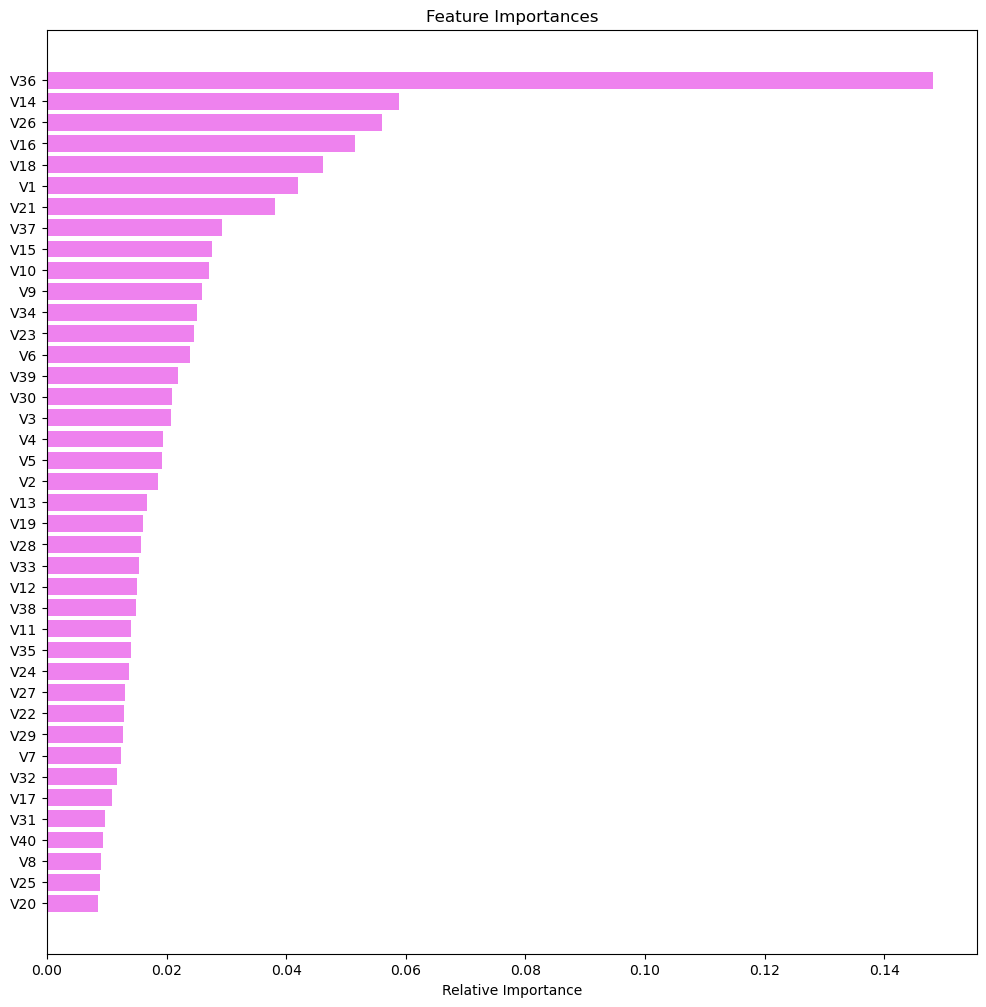

In [59]:
feature_names = X_train.columns
importances =  xgb2.feature_importances_ ## code to check the feature importance of the best model
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

#### Observations on final model feature importance:

* V36, V14, V26, V16, V18 are the top 5 features of importance according to best model


## Let's use Pipelines to build final model

- Since we have only one datatype in the data, we don't need to use column transformer here

In [60]:
model_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        (
            "XGB",
            XGBClassifier(
                subsample=0.9,
                scale_pos_weight=10,
                n_estimators=250,
                learning_rate=0.1,
                gamma=3,
                random_state=1,
                eval_metric="logloss",
            ),
        ),
    ]
)


In [61]:
# Separating target variable and other variables
X1 = data.drop(columns="Target")
Y1 = data["Target"]

# Since we already have a separate test set, we don't need to divide data into train and test

X_test1 = df_test.drop("Target", axis=1) ##  code to drop target variable from test data
y_test1 = df_test["Target"] ##  code to store target variable in y_test1

In [62]:
# We can't oversample/undersample data without doing missing value treatment, 
# so let's first treat the missing values in train set

imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)

# We don't need to impute missing values in test set as it will be done inside pipeline

In [63]:
# #code for oversampling on the  data
# # Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_over1, y_over1 = sm.fit_resample(X1, Y1)

In [64]:
# code to fit the model from above step

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=3, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_esti

In [65]:
## code to check performance on test set
model_pipeline_test = model_pipeline.predict(X_test) 
model_pipeline_test

array([0, 0, 0, ..., 0, 0, 0])


# Conclusions:

* ReneWind is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the confidentail data.
* Data has 40 predictors, 20000 observations in the training set and 5000 in the test set
* Project objective is to build various classification models, tune them, and find the best one that will help identify failures so generators could be repaired before failing/breaking to reduce the overall maintenance cost
* It is given that cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.
* “1” in the target variables should be considered as “failure” and “0” represents “No failure”.

# Business Insights:

* A total of 21 classification models were built based on original data(7), oversampled(7) and undersampled data(7)

* Out of these, 5 top performing models were hypertuned after accounting for class imbalance and missing value etc in data

* Hypertuning was performed by employing best algorithm parameters and models cross validated on recall score, accuracy, precision and F1 scores

* Out of 5 models tuned, XGboost was chosen as best model based on recall score (ReneWind has chosen Recall score as primary performance metric)

* Tuned XGBoost has Recall score of 84.8%, 98.2% accuracy, 84.2% precision, 84.5% F1 score on Test data

* A pipeline was built to productionize final model

* This model is generalizing well and performs well in production

* V36, V14, V26, V16, V18 are the top 5 features of importance according to best model

* Predictive maintenance not only uses sensors to monitor the current state of an asset, but also involves following trends to predict when issues might develop in the future. 

* ReneWind can focus on these specific attributes for trend in measurements to assist in predictive analysis about sensor failure

* If a certain trend in measurements from these attributes indicates a future problem, ReneWind can schedule maintenance to prevent the same

* ReneWind can build specific ML models to further analyse/predict each of these attributes in a deepdive mode

* ReneWind can use all these models collectively to reduce failure and maintenance cost

